In [1]:
#Function to resize images for Rcnn
from PIL import Image
import os
import argparse

def rescale_img(dir,size):
    for img in os.listdir(dir):
        im = Image.open(dir+'\\'+img)
        im_resized = im.resize(size,Image.ANTIALIAS)
        im_resized.save(dir+'\\'+img)

In [3]:
dir = r'C:\Users\gajay\OneDrive\Desktop\mini\images\train'
size=(750,420)
rescale_img(dir,size)

In [13]:
#XML TO CSV
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    for folder in ['train','test']:
        image_path = os.path.join(os.getcwd(), ( r'C:\Users\gajay\OneDrive\Desktop\mini\images\\' + folder))
        xml_df = xml_to_csv(image_path)
        xml_df.to_csv((r'C:\Users\gajay\OneDrive\Desktop/mini/images/' + folder + '_labels.csv'), index=None)
        print('Successfully converted xml to csv.')

path = r'C:\Users\gajay\OneDrive\Desktop\mini\images'
xml_to_csv(path)
main()



Successfully converted xml to csv.
Successfully converted xml to csv.


In [22]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


In [23]:

from utils import label_map_util

from utils import visualization_utils as vis_util
%matplotlib inline

In [24]:

PATH_TO_FROZEN_GRAPH = r'C:\Users\gajay\OneDrive\Desktop\mini\inference_graph\frozen_inference_graph.pb'
PATH_TO_LABELS = r'C:\Users\gajay\OneDrive\Desktop\mini\training\labelmap.pbtxt'
#PATH_TO_FROZEN_GRAPH = r'C:\Users\gajay\Downloads\Gun-Detector-master\models\research\object_detection\training\inference_graph\frozen_inference_graph.pb'
#PATH_TO_LABELS = r'C:\Users\gajay\Downloads\Gun-Detector-master\models\research\object_detection\training\object-detection.pbtxt'

In [25]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [26]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [27]:

def run_inference_for_single_image(image, graph):
    if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

    # Run inference
    output_dict = sess.run(tensor_dict,
                            feed_dict={image_tensor: np.expand_dims(image, 0)})

    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict[
        'detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [28]:

import cv2
import numpy as np

 
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture(r'C:\Users\gajay\OneDrive\Desktop\gg.mp4')
pred=[]
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
 


 
try:
    with detection_graph.as_default():
        with tf.Session() as sess:
                # Get handles to input and output tensors
                ops = tf.get_default_graph().get_operations()
                all_tensor_names = {output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                  'num_detections', 'detection_boxes', 'detection_scores',
                  'detection_classes', 'detection_masks'
                ]:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)

                while(cap.isOpened()):
                    ret, image_np = cap.read()
                    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
                    image_np_expanded = np.expand_dims(image_np, axis=0)
                    # Actual detection.
                    output_dict = run_inference_for_single_image(image_np, detection_graph)
                    # Visualization of the results of a detection.
                    vis_util.visualize_boxes_and_labels_on_image_array(
                        image_np,
                        output_dict['detection_boxes'],
                        output_dict['detection_classes'],
                        output_dict['detection_scores'],
                        category_index,
                        instance_masks=output_dict.get('detection_masks'),
                        use_normalized_coordinates=True,
                        line_thickness=8)
                    cv2.imshow('skynet', cv2.resize(image_np, (800, 600)))
                    pred.append(output_dict['detection_scores'].max())
                    if cv2.waitKey(25) & 0xFF == ord('q'):
                        cap.release()
                        cv2.destroyAllWindows()
                        break

                            
except Exception as e:
    print(e)
    cap.release()
    
cap.release()
cv2.destroyAllWindows()

int() argument must be a string, a bytes-like object or a number, not 'NoneType'


In [29]:
from utils.visualization_util import *
pred

[0.32018152,
 0.42489672,
 0.3766875,
 0.36687925,
 0.44759658,
 0.46492305,
 0.39919087,
 0.27786645,
 0.43583465,
 0.4944559,
 0.48431242,
 0.5837409,
 0.37888286,
 0.36707142,
 0.32638335,
 0.3869421,
 0.15688519,
 0.4501874,
 0.3477237,
 0.3176444,
 0.32743528,
 0.30815575,
 0.27832204,
 0.29504848,
 0.3372691,
 0.31640238,
 0.3130378,
 0.35530478,
 0.30517718,
 0.2418266,
 0.22647195,
 0.32929766,
 0.2542737,
 0.3001072,
 0.30378962,
 0.3049089,
 0.3224086,
 0.36973178,
 0.26335886,
 0.29552636,
 0.25773278,
 0.25828898,
 0.24204028,
 0.20191279,
 0.22208583,
 0.23114473,
 0.2726397,
 0.26243842,
 0.20166604,
 0.25891048,
 0.23123273,
 0.21595535,
 0.21603963,
 0.18497035,
 0.19152325,
 0.13756403,
 0.17776155,
 0.18394028,
 0.14492744,
 0.13019954,
 0.11546905,
 0.12362698,
 0.14798641,
 0.12057125,
 0.18229474,
 0.17001863,
 0.16955811,
 0.19871473,
 0.22786744,
 0.11211332,
 0.14893061,
 0.15386799,
 0.22928695,
 0.2227713,
 0.21907741,
 0.23684445,
 0.16558488,
 0.23563373,
 0

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


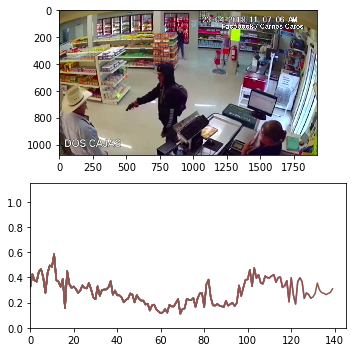

In [30]:
visualize_predictions(r'C:\Users\gajay\OneDrive\Desktop\gg.mp4', pred, r'C:\Users\gajay\OneDrive\Desktop\gg.gif')

Number of clips in the video :  10
skynet.......
Processed clip :  0
Processed clip :  1
Processed clip :  2
Processed clip :  3
Processed clip :  4
Processed clip :  5
Processed clip :  6
Processed clip :  7
Processed clip :  8
[3.9339066e-06 3.9339066e-06 5.8710575e-06 1.0281801e-05 1.0281801e-05
 1.9997358e-05 5.2094460e-05 5.2094460e-05 5.2094460e-05 5.2094460e-05
 4.6908855e-05 4.8190355e-05 4.8190355e-05 4.3213367e-06 4.7683716e-07
 4.7683716e-07 4.7683716e-07 4.7683716e-07 1.7285347e-06 7.9870224e-06
 7.9870224e-06 4.5895576e-06 2.9504299e-06 2.9504299e-06 2.9504299e-06
 2.9504299e-06 1.1324883e-06 5.3644180e-07 5.3644180e-07 8.6426735e-07
 2.1159649e-06 2.1159649e-06]


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


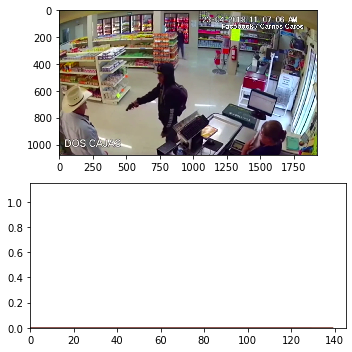

In [31]:
import os
from c3d import *
from classifier import *
from utils.visualization_util import *
import numpy as np




video_name = os.path.basename(cfg.sample_video_path).split('.')[0]

    
video_clips, num_frames = get_video_clips(cfg.sample_video_path)

print("Number of clips in the video : ", len(video_clips))

   
feature_extractor = c3d_feature_extractor()
classifier_model = build_classifier_model()

print("skynet.......")

rgb_features = []
for i, clip in enumerate(video_clips):
    clip = np.array(clip)
    if len(clip) < params.frame_count:
        continue

    clip = preprocess_input(clip)
    rgb_feature = feature_extractor.predict(clip)[0]
    rgb_features.append(rgb_feature)
    print("Processed clip : ", i)

rgb_features = np.array(rgb_features)


rgb_feature_bag = interpolate(rgb_features, params.features_per_bag)

 
predictions = classifier_model.predict(rgb_feature_bag)

predictions = np.array(predictions).squeeze()
print(predictions)
predictions = extrapolate(predictions, num_frames)

save_path = os.path.join(cfg.output_folder, video_name + '.gif')

visualize_predictions(cfg.sample_video_path, predictions, save_path)




In [32]:
pred=np.array(pred)
if len(pred) < len(predictions):
    new = predictions.copy()
    new[:len(pred)] += pred
else:
    new = pred.copy()
    new[:len(predictions)] += predictions
new[new<0.58]=0

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


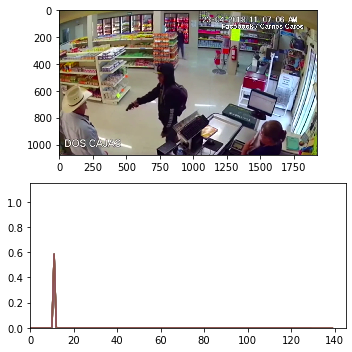

In [33]:

visualize_predictions(r'C:\Users\gajay\OneDrive\Desktop\gg.mp4',new, r'C:\Users\gajay\OneDrive\Desktop\skynet.gif')

In [105]:
new[new<0.58]=0

In [106]:
new

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [10]:
pred

[0.32018152,
 0.42489672,
 0.3766875,
 0.36687925,
 0.44759658,
 0.46492305,
 0.39919087,
 0.27786645,
 0.43583465,
 0.4944559,
 0.48431242,
 0.5837409,
 0.37888286,
 0.36707142,
 0.32638335,
 0.3869421,
 0.15688519,
 0.4501874,
 0.3477237,
 0.3176444,
 0.32743528,
 0.30815575,
 0.27832204,
 0.29504848,
 0.3372691,
 0.31640238,
 0.3130378,
 0.35530478,
 0.30517718,
 0.2418266,
 0.22647195,
 0.32929766,
 0.2542737,
 0.3001072,
 0.30378962,
 0.3049089,
 0.3224086,
 0.36973178,
 0.26335886,
 0.29552636,
 0.25773278,
 0.25828898,
 0.24204028,
 0.20191279,
 0.22208583,
 0.23114473,
 0.2726397,
 0.26243842,
 0.20166604,
 0.25891048,
 0.23123273,
 0.21595535,
 0.21603963,
 0.18497035,
 0.19152325,
 0.13756403,
 0.17776155,
 0.18394028,
 0.14492744,
 0.13019954,
 0.11546905,
 0.12362698,
 0.14798641,
 0.12057125,
 0.18229474,
 0.17001863,
 0.16955811,
 0.19871473,
 0.22786744,
 0.11211332,
 0.14893061,
 0.15386799,
 0.22928695,
 0.2227713,
 0.21907741,
 0.23684445,
 0.16558488,
 0.23563373,
 0